In [1]:
# from regelum.scenario import Scenario
from regelum.simulator import CasADi
import numpy as np

from regelum.utils import rg
from regelum.model import ModelWeightContainer
# Max Iteration count may be added in opt_options={"print_level": 0, "max_iter": MAX_ITER},
from regelum.optimizable.core.configs import CasadiOptimizerConfig
from regelum.predictor import EulerPredictor
from regelum.objective import RunningObjective
from regelum.critic import CriticTrivial
from regelum.scenario import RLScenario
from regelum.event import Event

import sys
sys.path.append('../')

from src.system import HydraulicSystem, StationaryHydraulicSystem
from src.observer import StationaryHydraulicObserver
from src.objective import HydraulicObjectiveModel
from src.policy import MPC

In [2]:
from regelum.callback import (
    ScenarioStepLogger,
    # StateTracker,
    # HistoricalDataCallback,
)
from src.callback import HistoricalDataCallback, SimulatorStepLogger

from regelum import set_ipython_env
%matplotlib inline
callbacks = [SimulatorStepLogger, ScenarioStepLogger, HistoricalDataCallback]
ScenarioStepLogger.cooldown = 0.01
callbacks = set_ipython_env(callbacks=callbacks, interactive=True)

In [3]:
MAX_STEP = 1e-7
PREDICTION_HORIZON = 5
FINAL_TIME = 10e-3
SAMPLING_TIME = 1e-3
ACTION_SIZE = 1

pred_step_size = 1 * SAMPLING_TIME

# Define the initial state
p_atm = 1e5
initial_state = rg.array([1e3, 0, 0, p_atm, p_atm])

model = ModelWeightContainer(
    dim_output=ACTION_SIZE, 
    weights_init=rg.zeros((PREDICTION_HORIZON + 1, ACTION_SIZE), rc_type=rg.CASADI)
)  # A trivial model contains our predicted actions

system = HydraulicSystem(
    init_state=initial_state
)
system_model = StationaryHydraulicSystem(
    init_state=initial_state
)
observer = StationaryHydraulicObserver(
    system=system_model
)
predictor = EulerPredictor(
    system=system_model, pred_step_size=pred_step_size
)  # Predictor is used for MPC-prediction

# RUNNING OBJECTIVE
running_objective_model = HydraulicObjectiveModel(
    system=system_model,
    quad_matrix_type="diagonal", weights=[1, 0, 0]
)  # A quadratic model for running (a.k.a. instant) objective. We 
running_objective = RunningObjective(
    model=running_objective_model
)  # Wrap `running_objective_model` into `RunningObjective` class

simulator = CasADi(
    system=system,
    state_init=initial_state,
    action_init=rg.array([0]),
    time_final=FINAL_TIME,
    max_step=MAX_STEP,
)

scenario = RLScenario(
    policy=MPC(
        model=model,
        system=system_model,
        action_bounds=system_model.action_bounds,
        optimizer_config=CasadiOptimizerConfig(),
        prediction_horizon=PREDICTION_HORIZON,
        running_objective=running_objective,
        predictor=predictor
    ),
    observer = observer,
    critic=CriticTrivial(),  # mocked critic
    running_objective=running_objective,
    policy_optimization_event=Event.compute_action,  # run policy optimization on each step
    discount_factor=1.0,
    sampling_time=SAMPLING_TIME,
    simulator=simulator,
    N_episodes=1,
    N_iterations=1,
)

In [4]:
# the output of the cell is omitted
scenario.run()


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************



[11:19:48] INFO     runn. objective: 3.71, state est.: [1000.    0.    0.], observation: [0. 0.],  ]8;id=450936;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py\callback.py]8;;\:]8;id=323889;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py#1109\1109]8;;\
                    action: [20.], value: 0.0037, time: 0.0000 (0.0%), episode: 1/1, iteration:                    
                    1/1                                                                                            

[11:19:54] INFO     runn. objective: 2.92, state est.: [1000.06  117.74    7.86], observation: [   ]8;id=273412;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py\callback.py]8;;\:]8;id=677635;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py#1109\1109]8;;\
                    0.22 432.48], action: [20.], value: 0.0066, time: 0.0010 (10.0%), episode:                     
                    1/1, iteration: 1/1                                                                            

[11:20:01] INFO     runn. objective: 1.29, state est.: [1000.22  189.     12.63], observation: [   ]8;id=587439;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py\callback.py]8;;\:]8;id=561534;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py#1109\1109]8;;\
                    0.79 694.23], action: [3.37], value: 0.0079, time: 0.0020 (20.0%), episode:                    
                    1/1, iteration: 1/1                                                                            

[11:20:09] INFO     runn. objective: 0.30, state est.: [1000.38  134.83    9.  ], observation: [   ]8;id=860310;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py\callback.py]8;;\:]8;id=97916;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py#1109\1109]8;;\
                    1.38 495.24], action: [-7.11], value: 0.0082, time: 0.0030 (30.0%), episode:                   
                    1/1, iteration: 1/1                                                                            

[11:20:20] INFO     runn. objective: 0.06, state est.: [1000.46   39.89    2.66], observation: [   ]8;id=346348;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py\callback.py]8;;\:]8;id=987309;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py#1109\1109]8;;\
                    1.69 146.52], action: [0.75], value: 0.0083, time: 0.0040 (40.0%), episode:                    
                    1/1, iteration: 1/1                                                                            

[11:20:31] INFO     runn. objective: 0.01, state est.: [1000.49   28.6     1.91], observation: [   ]8;id=712276;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py\callback.py]8;;\:]8;id=715107;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py#1109\1109]8;;\
                    1.81 105.06], action: [-1.49], value: 0.0083, time: 0.0050 (50.0%), episode:                   
                    1/1, iteration: 1/1                                                                            

[11:20:45] INFO     runn. objective: 0.00, state est.: [1000.51    8.55    0.57], observation: [   ]8;id=62925;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py\callback.py]8;;\:]8;id=622674;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py#1109\1109]8;;\
                    1.87 31.39], action: [0.15], value: 0.0083, time: 0.0060 (60.0%), episode:                     
                    1/1, iteration: 1/1                                                                            

[11:21:01] INFO     runn. objective: 0.00, state est.: [1000.52    6.09    0.41], observation: [   ]8;id=477164;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py\callback.py]8;;\:]8;id=41421;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py#1109\1109]8;;\
                    1.9  22.37], action: [-0.32], value: 0.0083, time: 0.0070 (70.0%), episode:                    
                    1/1, iteration: 1/1                                                                            

[11:21:18] INFO     runn. objective: 0.00, state est.: [1000.52    1.83    0.12], observation:     ]8;id=701334;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py\callback.py]8;;\:]8;id=436463;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py#1109\1109]8;;\
                    [1.92 6.7 ], action: [0.03], value: 0.0083, time: 0.0080 (80.0%), episode:                     
                    1/1, iteration: 1/1                                                                            

[11:21:36] INFO     runn. objective: 0.00, state est.: [1000.52    1.29    0.09], observation:     ]8;id=424201;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py\callback.py]8;;\:]8;id=631087;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py#1109\1109]8;;\
                    [1.92 4.75], action: [-0.07], value: 0.0083, time: 0.0090 (90.0%), episode:                    
                    1/1, iteration: 1/1                                                                            

[11:21:56] INFO     runn. objective: 0.00, state est.: [1000.52    0.39    0.03], observation:     ]8;id=747362;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py\callback.py]8;;\:]8;id=681196;file:///Users/vulf/.pyenv/versions/3.11.8/envs/acm-env/lib/python3.11/site-packages/regelum/callback.py#1109\1109]8;;\
                    [1.92 1.45], action: [0.01], value: 0.0083, time: 0.0100 (100.0%), episode:                    
                    1/1, iteration: 1/1                                                                            

,time,running_objective,current_value,episode_id,iteration_id,throttle action [µm],jet length [mm],jet velocity [mm/s],piston position [µm],piston velocity [µm/s],throttle position [µm]
0,0.000000,3.710643,0.003711,1,1,20.000000,0.000000,0.000000,1000.000000,0.000000,0.000000
1,0.001000,2.919688,0.006630,1,1,20.000000,0.217593,432.482032,1000.059240,117.743233,7.856631
2,0.002000,1.287058,0.007917,1,1,3.366563,0.791817,694.231119,1000.215572,189.004422,12.629617
3,0.003000,0.299487,0.008217,1,1,-7.111151,1.379049,495.240647,1000.375446,134.829266,8.999252
4,0.004000,0.057826,0.008275,1,1,0.750924,1.685832,146.520690,1000.458968,39.890258,2.659630
5,0.005000,0.013571,0.008288,1,1,-1.491658,1.809810,105.055304,1000.492721,28.601306,1.906858
6,0.006000,0.002634,0.008291,1,1,0.153753,1.874984,31.389021,1000.510464,8.545661,0.569714
7,0.007000,0.000616,0.008292,1,1,-0.316778,1.901481,22.365722,1000.517678,6.089068,0.405940
8,0.008000,0.000120,0.008292,1,1,0.031959,1.915365,6.704835,1000.521458,1.825391,0.121693
9,0.009000,0.000028,0.008292,1,1,-0.066606,1.921013,4.750175,1000.522996,1.293235,0.086216


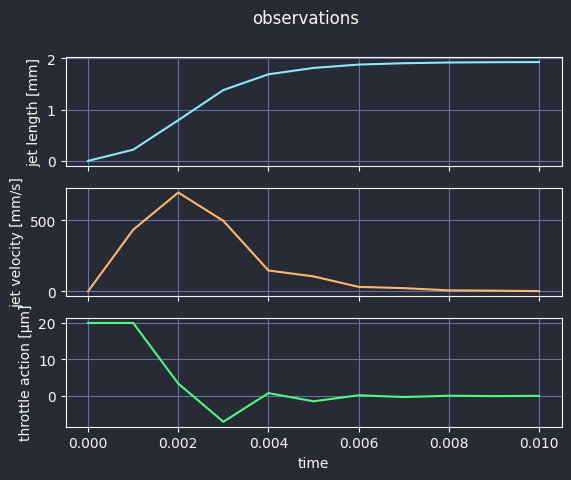

In [5]:
display(callbacks[-1].data)
callbacks[-1].plot(name="observations");